In [29]:
import shapely
from shapely import wkt
from shapely import (
    Point, 
    MultiPoint, 
    Polygon, 
    MultiPolygon, 
    LineString, 
    MultiLineString,
    GeometryCollection
)
slab_edge_file = 'slab_edge.wkt.txt'
slab_openings_file = 'slab_openings.wkt.txt'
walls_file = 'walls.wkt.txt'
columns_file = 'columns.wkt.txt'
load_heavy_file = 'load_heavy.wkt.txt'
load_light_file = 'load_light.wkt.txt'

In [30]:
import json

with open('floor_data.json', 'r') as file:
    floor_data = json.load(file)

floor_data

{'slab_outline': [[4500.0, 0.0],
  [0.0, 0.0],
  [0.0, 3000.0],
  [1000.0, 3000.0],
  [1000.0, 5500.0],
  [0.0, 5500.0],
  [0.0, 15000.0],
  [20000.0, 15000.0],
  [20000.0, 0.0],
  [16000.0, -2500.0],
  [12500.0, 0.0],
  [7500.0, -1000.0],
  [4500.0, -1000.0]],
 'slab_openings': [[[12500.0, 11000.0],
   [18500.0, 11000.0],
   [18500.0, 13000.0],
   [12500.0, 13000.0]],
  [[11500.0, 4000.0],
   [14500.0, 4000.0],
   [14500.0, 5000.0],
   [11500.0, 5000.0]]],
 'occupancy_a': [[10500.0, 15000.0],
  [10500.0, -400.0000000000002],
  [7500.0, -1000.0],
  [4500.0, -1000.0],
  [4500.0, 0.0],
  [0.0, 0.0],
  [0.0, 3000.0],
  [1000.0, 3000.0],
  [1000.0, 5500.0],
  [0.0, 5500.0],
  [0.0, 15000.0]],
 'occupancy_b': [[10500.0, 15000.0],
  [10500.0, -400.0000000000002],
  [12500.0, 0.0],
  [16000.0, -2500.0],
  [20000.0, 0.0],
  [20000.0, 15000.0]],
 'walls': [[[8300.0, 7000.0],
   [8300.0, 9900.0],
   [4500.0, 9900.0],
   [4500.0, 7000.0],
   [4900.0, 7000.0],
   [4900.0, 9500.0],
   [7900.0, 9500

In [31]:

with open(slab_edge_file, 'r') as file:
    slab_outline = wkt.load(file)
with open(slab_openings_file, 'r') as file:
    slab_openings = wkt.load(file)
with open(columns_file, 'r') as file:
    columns = wkt.load(file)
with open(walls_file, 'r') as file:
    walls = wkt.load(file)
with open(load_heavy_file, 'r') as file:
    load_heavy = wkt.load(file)
with open(load_light_file, 'r') as file:
    load_light = wkt.load(file)


In [52]:

slab_outline = floor_data.get('slab_outline', [])
slab_openings = floor_data.get('slab_openings',[])
columns = floor_data.get('columns',[])
walls = floor_data.get('walls',[])
load_light = floor_data.get('occupancy_a',[])
load_heavy = floor_data.get('occupancy_b',[])

slab_outline = Polygon(slab_outline)
load_heavy = Polygon(load_heavy)
load_light = Polygon(load_light)
slab_openings = MultiPolygon([Polygon(outline) for outline in slab_openings])
columns = MultiPolygon([Polygon(outline) for outline in columns])
walls = MultiPolygon([Polygon(outline) for outline in walls])



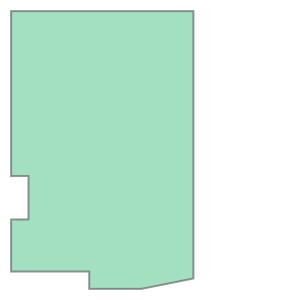

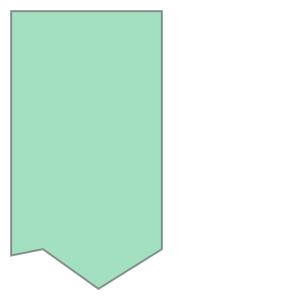

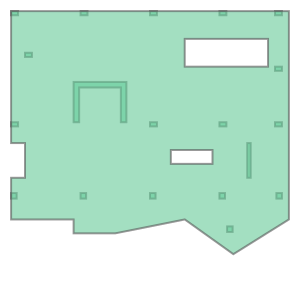

In [33]:

#slab = Polygon(shell = slab_outline.exterior.coords, holes = slab_openings.geoms)
slab = Polygon(
    shell = slab_outline.exterior.coords,
    holes = [opening.exterior.coords for opening in slab_openings.geoms]
)
display(load_light)
display(load_heavy)
GeometryCollection([columns,walls,slab])

In [34]:
list(walls.geoms)

[<POLYGON ((8300 7000, 8300 9900, 4500 9900, 4500 7000, 4900 7000, 4900 9500,...>,
 <POLYGON ((17000 3000, 17250 3000, 17250 5500, 17000 5500, 17000 3000))>]

## Start
The key to this procedure is that I need to identify which point is a part of which polygon after the voronoi regions are calculated because the order of the points and voronoi regions is going to become scrambled.

So, I will make the assumption that each point can only be a part of one polygon and then make a dictionary that allows me to look up points by their polygon so that I can group them after the voronoi procedure. Using this look-up tool, I will be able to create a second look-up dictionary based on trib areas keyed by polygons. Combining both lookups will allow me to correlate all the trib regions with their original generating polygons.

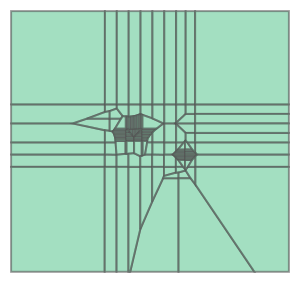

In [35]:
import more_itertools # This library is included in PfSE. Look it up on PyPI for docs (useful)

# Make sure the first/last point is not duplicated in the list
column_points = [list(column.exterior.coords)[:-1] for column in columns.geoms]

# Break up wall in to smaller segments according to a maximum segment length
max_seg_length = 300

segmented_walls = [
    Polygon(shapely.segmentize(wall.exterior, max_seg_length))
    for wall in walls.geoms
]
wall_points = [list(wall.exterior.coords)[:-1] for wall in segmented_walls]

grouped_points = column_points + wall_points
flattened_points = list(more_itertools.flatten(grouped_points))
voronoi_source = MultiPoint(flattened_points)
v_polys = shapely.voronoi_polygons(voronoi_source)
v_polys

## Get the clipped voronoi regions

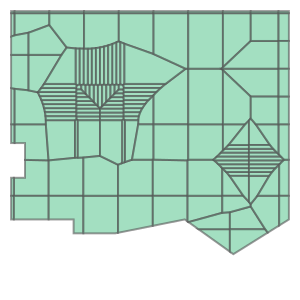

In [36]:
# this is option to include the openings
trib_components_wo_openings = [slab_outline & v_poly for v_poly in v_polys.geoms]
GeometryCollection(trib_components_wo_openings)

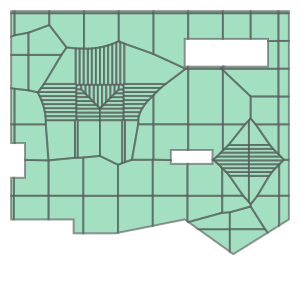

In [37]:
trib_components = [slab & v_poly for v_poly in v_polys.geoms]
GeometryCollection(trib_components)

## Reorder trib components to match order of source points

In [38]:
reordered_components = []
for point in flattened_points: # Iterate by points to prioritize point order
    for poly in trib_components:
        if poly.contains(Point(point)) or poly.touches(Point(point)):
            reordered_components.append(poly)

In [39]:
len(reordered_components)

153

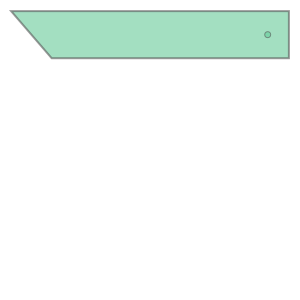

In [40]:
idx = 152
display(GeometryCollection([reordered_components[idx], Point(flattened_points[idx])]))

## Group trib components by their source geometry

Using a `dict` where the keys are points (`tuple`) and the values are Polygons can be efficient to find which points are in which polygons and, thus, should be grouped with the neighbouring trib components.

### Create the point-polygon lookup

In [41]:
all_polygons = list(columns.geoms) + segmented_walls

poly_lookup = {}
for idx, point_group in enumerate(grouped_points):
    for point in point_group:
        poly_lookup.update({point: all_polygons[idx]})

### Create the polygon-trib component lookup

In [42]:
trib_lookup = {}
for idx, trib_component in enumerate(reordered_components):
    corresponding_point = flattened_points[idx]
    corresponding_polygon = poly_lookup[corresponding_point]
    trib_component_list = trib_lookup.get(corresponding_polygon, [])
    trib_component_list.append(trib_component)
    trib_lookup[corresponding_polygon] = trib_component_list

### Perform a union on all trib components corresponding to each input geometry

In [43]:
trib_area_lookup = {}
for polygon, trib_components in trib_lookup.items():
    trib_area_lookup[polygon] = shapely.unary_union(trib_components)
#    display(GeometryCollection([polygon, *trib_components]))

## View Results

In [44]:
trib_areas = trib_area_lookup.values()
source_geometry = trib_area_lookup.keys()
GeometryCollection([*source_geometry, *trib_areas])
list(trib_areas)

[<POLYGON ((2750 13998.148, 1250 13442.593, 250 13257.407, 0 13164.815, 0 148...>,
 <POLYGON ((2700 0, 200 0, 0 0, 0 1700, 0 3000, 200 3000, 1000 3000, 1000 428...>,
 <POLYGON ((7750 12827.219, 7569.231 12743.787, 7276.923 12626.677, 6984.615 ...>,
 <POLYGON ((7700 -960, 7500 -1000, 5200 -1000, 4500 -1000, 4500 0, 2700 0, 27...>,
 <POLYGON ((12563.636 10850, 10250 11910.417, 8153.846 12652.804, 7861.538 12...>,
 <POLYGON ((12700 -142.857, 12500 0, 10200 -460, 7700 -960, 7700 1700, 7700 3...>,
 <MULTIPOLYGON (((12750 10850, 12750 11000, 15250 11000, 15294.286 11000, 152...>,
 <POLYGON ((17125 1263.333, 17250 1109.167, 17250 933.125, 15750 520.625, 152...>,
 <POLYGON ((0 5500, 0 6850, 0 9456.383, 250 9403.191, 1250 9296.809, 1922.049...>,
 <POLYGON ((10250 4304.167, 10200 4300, 8700 4300, 9150 6850, 9150 7145, 9199...>,
 <POLYGON ((12750 6850, 12750 10850, 15150 10850, 15250 10741.892, 17250 8850...>,
 <POLYGON ((17250 933.125, 17250 1109.167, 17729.054 1700, 18584.61 3138.889,...>,
 <PO

In [45]:
# Export to rhino for checking

def multipolygon_to_polygon_list(mp):
    result = []
    for obj in mp.geoms:
        coords = obj.exterior.coords
        polygon = Polygon(coords)
        result.append(polygon)
    return result


objects = list(trib_areas)
polygons = []
for obj in list(trib_areas):
    if obj.geom_type == 'MultiPolygon':
        polygons += multipolygon_to_polygon_list(obj)
    elif obj.geom_type == 'Polygon':
        polygons.append(obj)

polygons
mp = MultiPolygon(polygons)
mp.wkt

'MULTIPOLYGON (((2750 13998.148148148148, 1250 13442.592592592593, 250 13257.407407407407, 0 13164.814814814814, 0 14850, 0 15000, 250 15000, 2750 15000, 2750 14850, 2750 13998.148148148148)), ((2700 0, 200 0, 0 0, 0 1700, 0 3000, 200 3000, 1000 3000, 1000 4288.541666666667, 2694.7574334898277 4253.234220135629, 2700 4249.019607843137, 2700 1700, 2700 0)), ((7750 12827.218934911243, 7569.2307692307695 12743.78698224852, 7276.923076923076 12626.676528599606, 6984.615384615385 12527.366863905325, 6692.3076923076915 12445.85798816568, 6400 12382.149901380672, 6107.692307692308 12336.242603550296, 5815.384615384615 12308.136094674555, 5523.076923076923 12297.830374753452, 5250 12304.83234714004, 5230.7692307692305 12303.322238658777, 4938.461538461539 12298.169378698225, 4646.153846153846 12310.817307692309, 3999.7087378640776 12378.155339805826, 2750 13998.148148148148, 2750 14850, 2750 15000, 5250 15000, 7750 15000, 7750 14850, 7750 12827.218934911243)), ((7700 -960, 7500 -1000, 5200 -10

## Create a `ColumnArea` dataclass and calculate the percentage areas of each occupancy

In [46]:
from dataclasses import dataclass
from typing import Optional
import numpy as np

@dataclass
class ColumnArea:
    column_outline: Polygon
    trib_area: Polygon
    occupancies: dict
    column_load: Optional[np.ndarray] = None
    def get_combined_load(self, load_factors:np.ndarray = np.zeros(3), scale_factor:float = 1.0):
        if self.column_load.any():
            return (self.column_load * load_factors).sum() * scale_factor
        else:
            return 0


occupancy_areas = {"heavy_occupancy": load_heavy, "light_occupancy": load_light}
column_areas_acc = []

for column, trib_area in trib_area_lookup.items():
    column_area = ColumnArea(column, trib_area, {})
    for occupancy, area_load in occupancy_areas.items():
        intersection = trib_area & area_load
        if not intersection.is_empty:
            column_area.occupancies.update({occupancy: intersection.area / trib_area.area})
    column_areas_acc.append(column_area)



In [47]:
column_areas_acc[4]

ColumnArea(column_outline=<POLYGON ((10000 14700, 10500 14700, 10500 15000, 10000 15000, 10000 14700))>, trib_area=<POLYGON ((12563.636 10850, 10250 11910.417, 8153.846 12652.804, 7861.538 12...>, occupancies={'heavy_occupancy': 0.515170590128715, 'light_occupancy': 0.48482940987128476}, column_load=None)

## Find the total floor load per column

In [48]:
import json
import numpy as np

with open('occupancy_loading.json', 'r') as file:
    occupancy_loading = json.load(file)

num_load_cases = len(list(occupancy_loading.values())[0])

occupancy_vector = {occupancy: np.array(list(loads.values())) for occupancy, loads in occupancy_loading.items()}

for column_area in column_areas_acc:
    total_load = np.zeros(num_load_cases)
    for occupancy, ratio in column_area.occupancies.items():
        total_load = total_load + ratio * occupancy_vector[occupancy] * column_area.trib_area.area / 1e6
    column_area.column_load = np.array(total_load)

column_areas_acc[4]

ColumnArea(column_outline=<POLYGON ((10000 14700, 10500 14700, 10500 15000, 10000 15000, 10000 14700))>, trib_area=<POLYGON ((12563.636 10850, 10250 11910.417, 8153.846 12652.804, 7861.538 12...>, occupancies={'heavy_occupancy': 0.515170590128715, 'light_occupancy': 0.48482940987128476}, column_load=array([84.90209551, 55.49209308, 15.26013348]))

In [49]:
column_areas_acc[4].trib_area.area / 1e6

15.260133478762368

In [50]:
col = column_areas_acc[4]
display(col.column_load)
ult = col.get_combined_load(np.array([1.4,1.7,0]))
srv = col.get_combined_load(np.array([1.0,1.0,0]))
display(ult)
display(srv)
display(ult/srv)

array([84.90209551, 55.49209308, 15.26013348])

np.float64(213.1994919498955)

np.float64(140.3941885907177)

np.float64(1.5185777566008982)